In [9]:
!pip install -Uqq fastbook
import fastbook



In [10]:
try:
  fastbook.setup_book()
except Exception as e:
  print(e)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:



mount failed: invalid oauth code


In [11]:
!mv /content/kaggle.json /root/.kaggle/kaggle.json


In [12]:
!chmod 600 /root/.kaggle/kaggle.json

In [13]:
!pip install dtreeviz

In [14]:
!pip install IPython

In [15]:
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

### Bluebook Auctioning bulldozers
Thats so random

In [16]:
creds = ''

In [17]:
cred_path = Path('/root/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
  cred_path.parent.mkdir(exist_ok=True)
  cred_path.write(creds)
  cred_path.chmod(0o600)

In [18]:
!dir '/root'

In [19]:
!mkdir '/root/.fastai'
!mkdir '/root/.fastai/archive/'

In [20]:
path = URLs.path('bluebook')
path

Path('/root/.fastai/archive/bluebook')

In [21]:
Path.BASE_PATH = path

In [22]:
if not path.exists():
  path.mkdir()
  api.competition_download_cli('bluebook-for-bulldozers', path=path)
  file_extract(path/'bluebook-for-bulldozers.zip')

path.ls(file_type='text')

  0%|          | 0.00/48.4M [00:00<?, ?B/s]

100%|██████████| 48.4M/48.4M [00:01<00:00, 25.5MB/s]


(#7) [Path('ValidSolution.csv'),Path('Test.csv'),Path('Machine_Appendix.csv'),Path('random_forest_benchmark_test.csv'),Path('Valid.csv'),Path('median_benchmark.csv'),Path('TrainAndValid.csv')]

we will start by setting it into a pandas dataframe

In [23]:
df =pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [24]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

At this point, a good next step is to handle ordinal columns. This refers to columns containing strings or similar, but where those strings have a natural ordering. For instance, here are the levels of ProductSize:

In [25]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [26]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [27]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

 in this case Kaggle tells us what metric to use: root mean squared log error (RMSLE) between the actual and predicted auction prices. We need do only a small amount of processing to use this: we take the log of the prices, so that rmse of that value will give us what we ultimately need:

In [28]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

In [29]:
df[dep_var].head()

0    11.097410
1    10.950807
2     9.210340
3    10.558414
4     9.305651
Name: SalePrice, dtype: float64

The first piece of data preparation we need to do is to enrich our representation of dates. The fundamental basis of the decision tree that we just described is bisection— dividing a group into two. We look at the ordinal variables and divide up the dataset based on whether the variable's value is greater (or lower) than a threshold, and we look at the categorical variables and divide up the dataset based on whether the variable's level is a particular level

### on why do we need to devide up dates

In order to help our algorithm handle dates intelligently, we'd like our model to know more than whether a date is more recent or less recent than another. We might want our model to make decisions based on that date's day of the week, on whether a day is a holiday, on what month it is in, and so forth. To do this, we replace every date column with a set of date metadata columns, such as holiday, day of week, and month. These columns provide categorical data that we suspect will be useful.

In [30]:
df = add_datepart(df, 'saledate')

In [31]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [32]:
' '.join(o for o in df.columns if o.startswith('sale'))

# notice newe columns

'saleWeek saleYear saleMonth saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

A second piece of preparatory processing is to be sure we can handle strings and missing data. Out of the box, sklearn cannot do either. Instead we will use fastai's class `TabularPandas`, which wraps a Pandas DataFrame and provides a few conveniences. To populate a `TabularPandas`, we will use two  `TabularProc`s, `Categorify` and `FillMissing`. A `TabularProc` is like a regular `Transform`, except that:

- It returns the exact same object that's passed to it, after modifying the object in place.
- It runs the transform once, when data is first passed in, rather than lazily as the data is accessed.

`Categorify` is a `TabularProc` that replaces a column with a numeric categorical column. `FillMissing` is a `TabularProc` that replaces missing values with the median of the column, and creates a new Boolean column that is set to `True` for any row where the value was missing. These two transforms are needed for nearly every tabular dataset you will use, so this is a good starting point for your data processing:

In [33]:
procs = [Categorify, FillMissing]

### creating our own validation set
that if we are going to have a useful validation set, we also want the validation set to be later in time than the training set. The Kaggle training data ends in April 2012, so we will define a narrower training dataset which consists only of the Kaggle training data from before November 2011, and we'll define a validation set consisting of data from after November 2011.

In [34]:
#splitting validation through a condition

cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

In [35]:
splits = (list(train_idx), list(valid_idx))

TabularPandas needs to be told which columns are continuous and which are categorical. We can handle that automatically using the helper function cont_cat_split:

In [36]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [37]:
dep_var

'SalePrice'

In [38]:
to = TabularPandas(df, procs, cat,cont, y_names=dep_var, splits=splits )

In [39]:
len(to.train), len(to.valid)

(404710, 7988)

In [40]:
to.show(3)

# data is still displayed as strings

,saleWeek,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,SalePrice
0,46,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1163635200,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,16,3,320,11.097410
1,13,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1080259200,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,26,4,86,10.950807
2,9,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,1077753600,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,26,3,57,9.210340


In [41]:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


In [42]:
to.items.head(3)

# even though underlying data is all numeric

,SalesID,SalePrice,MachineID,saleWeek,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,46,...,1,2647,1,1
1,1139248,10.950807,117657,13,...,1,2148,1,1
2,1139249,9.210340,434808,9,...,1,2131,1,1


In [43]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


The conversion of categorical columns to numbers is done by simply replacing each unique level with a number. The numbers associated with the levels are chosen consecutively as they are seen in a column, so there's no particular meaning to the numbers in categorical columns after conversion. The exception is if you first convert a column to a Pandas ordered category (as we did for ProductSize earlier), in which case the ordering you chose is used. We can see the mapping by looking at the classes attribute:

In [44]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [45]:
# (path/'to.pkl').save(to)
# to = (path/'to.pkl').load()

### creating the decision tree

In [46]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

Now that our data is all numeric, and there are no missing values, we can create a decision tree:

In [47]:
len(xs), len(y)

(404710, 404710)

In [48]:
xs[:5]

,saleWeek,UsageBand,fiModelDesc,fiBaseModel,...,saleMonth,saleDay,saleDayofweek,saleDayofyear
0,46,2,963,298,...,11,16,3,320
1,13,2,1745,529,...,3,26,4,86
2,9,1,336,111,...,2,26,3,57
3,20,1,3716,1381,...,5,19,3,139
4,30,3,4261,1538,...,7,23,3,204


In [49]:
y[:5]

0    11.097410
1    10.950807
2     9.210340
3    10.558414
4     9.305651
Name: SalePrice, dtype: float32

In [50]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=4,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

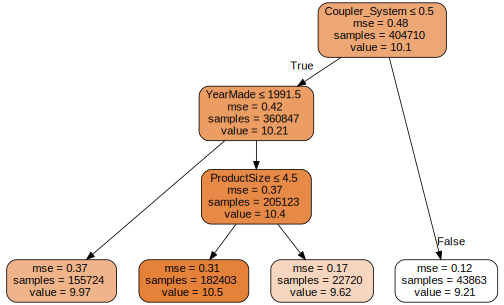

In [51]:
draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

In [52]:
samp_idx = np.random.permutation(len(y))[:500]

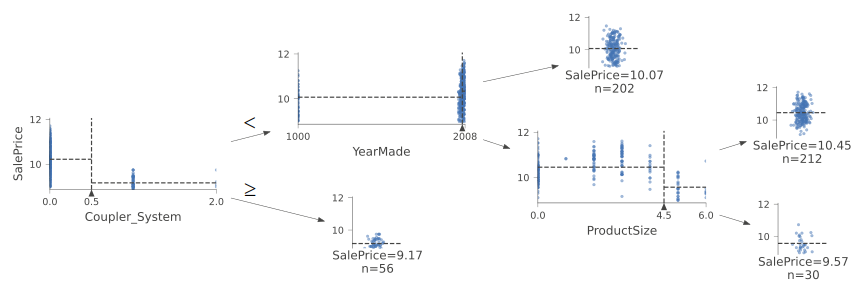

In [53]:

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [54]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

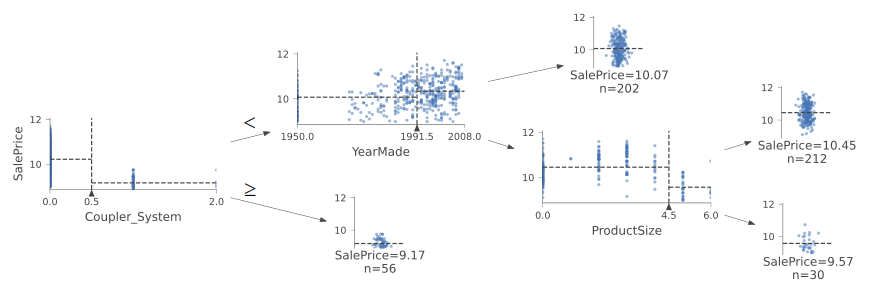

In [55]:
# since there are no bulldozers in year 2000

m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs,y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
          fontname='DejaVu Sans', scale=1.6, label_fontsize=10, orientation='LR')

In [56]:
m = DecisionTreeRegressor()
m.fit(xs,y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [57]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [58]:
m_rmse(m, xs, y)

1e-06

In [59]:
m_rmse(m, valid_xs, valid_y)

0.337021

In [60]:
m.get_n_leaves(), len(xs)

# we are overfitting very badly
# as many leaves as len of training set

(324545, 404710)

In [61]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248562, 0.323396)

In [62]:
m.get_n_leaves()

12397

### Random forests

1. Randomly choose a subset of the rows of your data (i.e., "bootstrap replicates of your learning set").
1. Train a model using this subset.
1. Save that model, and then return to step 1 a few times.
1. This will give you a number of trained models. To make a prediction, predict using all of the models, and then take the average of each of those model's predictions.



We can create a random forest just like we created a decision tree, except now, we are also specifying parameters that indicate how many trees should be in the forest, how we should subset the data items (the rows), and how we should subset the fields (the columns).

In the following function definition n_estimators defines the number of trees we want, max_samples defines how many rows to sample for training each tree, and max_features defines how many columns to sample at each split point (where 0.5 means "take half the total number of columns"). We can also specify when to stop splitting the tree nodes, effectively limiting the depth of the tree, by including the same min_samples_leaf parameter we used in the last section. Finally, we pass n_jobs=-1 to tell sklearn to use all our CPUs to build the trees in parallel. By creating a little function for this, we can more quickly try different variations in the rest of this chapter:

In [63]:
def rf(xs,y, n_estimators=40, max_samples=200_000, max_features=0.5,
       min_samples_leaf=5, **kwargs):
  return RandomForestRegressor(n_jobs =-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [64]:
m = rf(xs, y)

In [65]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.170917, 0.233975)

One of the most important properties of random forests is that they aren't very sensitive to the hyperparameter choices, such as max_features. You can set n_estimators to as high a number as you have time to train—the more trees you have, the more accurate the model will be. max_samples can often be left at its default, unless you have over 200,000 data points, in which case setting it to 200,000 will make it train faster with little impact on accuracy. max_features=0.5 and min_samples_leaf=4 both tend to work well, although sklearn's defaults work well too.

In [66]:
# to find the prediction by each of th eestimators

preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [67]:
# preds.mean gives the same results

r_mse(preds.mean(0), valid_y)

0.233975

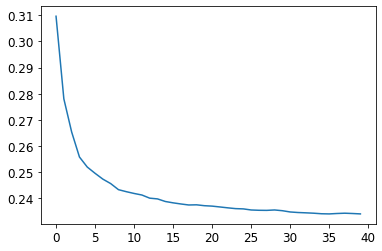

In [68]:
# what happens when we add more trees ?

plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

###out of bag error
 to find if the model is performing because of training error or some other thing
Recall that in a random forest, each tree is trained on a different subset of the training data. The OOB error is a way of measuring prediction error on the training set by only including in the calculation of a row's error trees where that row was *not* included in training. This allows us to see whether the model is overfitting, without needing a separate validation set.


In [69]:
r_mse(m.oob_prediction_, y)

#We can see that our OOB error is much lower than our validation set error.

0.210681

For tabular data, model interpretation is particularly important. For a given model, the things we are most likely to be interested in are:

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?

As we will see, random forests are particularly well suited to answering these questions. Let's start with the first one!

# finding tree variance for prediction confidence

We saw how the model averages the individual tree's predictions to get an overall prediction—that is, an estimate of the value. But how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions across the trees, instead of just the mean. This tells us the *relative* confidence of predictions. In general, we would want to be more cautious of using the results for rows where trees give very different results (higher standard deviations), compared to cases where they are more consistent (lower standard deviations).


In [70]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [71]:
preds.shape

(40, 7988)

In [72]:
preds_std = preds.std(0)

In [73]:
preds_std[:5]

# confidence vary widely
#  what items to bid on at auction, a low-confidence prediction might cause you to look more carefully at an item before you made a bid.

array([0.25065395, 0.11043862, 0.08242067, 0.26988508, 0.15730173])

### looking at feature importance

sklearn's random forest by looking in the feature_importances_ attribute.

In [74]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [75]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
59,YearMade,0.180070
7,ProductSize,0.113915
31,Coupler_System,0.104699
8,fiProductClassDesc,0.064118
33,Hydraulics_Flow,0.059110
56,ModelID,0.059087
51,saleElapsed,0.051231
4,fiSecondaryDesc,0.041778
32,Grouser_Tracks,0.037560
2,fiModelDesc,0.030933


In [76]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

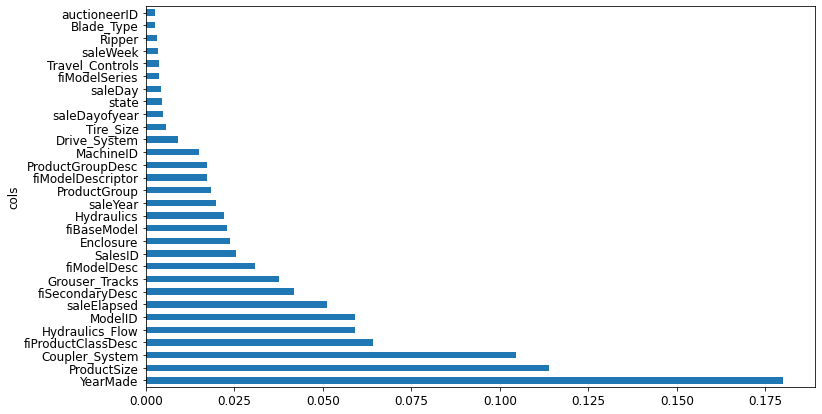

In [77]:
plot_fi(fi[:30])

### Removing low importance variables

to_keep = fi[fi.imp>0.005].cols
len(to_keep)
`

In [78]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [79]:
m = rf(xs_imp, y)

In [80]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181204, 0.230329)

In [81]:
len(xs.columns), len(xs_imp.columns)

(66, 21)

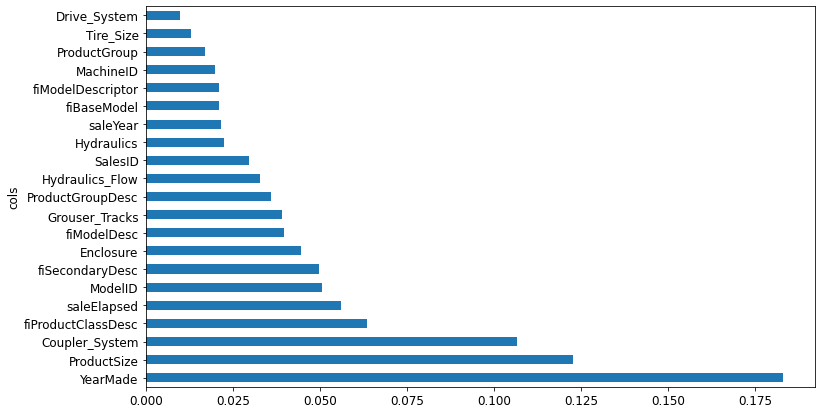

In [82]:
plot_fi(rf_feat_importance(m, xs_imp));

### Removing redundanr

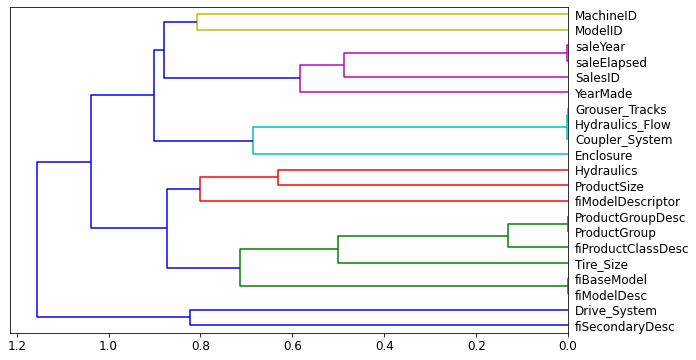

In [83]:
cluster_columns(xs_imp)

Let's try removing some of these closely related features to see if the model can be simplified without impacting the accuracy. First, we create a function that quickly trains a random forest and returns the OOB score, by using a lower `max_samples` and higher `min_samples_leaf`. The OOB score is a number returned by sklearn that ranges between 1.0 for a perfect model and 0.0 for a random model. (In statistics it's called *R^2*, although the details aren't important for this explanation.) We don't need it to be very accurate—we're just going to use it to compare different models, based on removing some of the possibly redundant columns:

In [84]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [85]:
get_oob (xs_imp)

0.8768243241012634

In [86]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'Coupler_System': 0.8780158691125818,
 'Grouser_Tracks': 0.8780246481379101,
 'Hydraulics_Flow': 0.8775975083138958,
 'ProductGroup': 0.8768277447901079,
 'ProductGroupDesc': 0.8773289113713139,
 'fiBaseModel': 0.8769194097714894,
 'fiModelDesc': 0.8760365396140016,
 'saleElapsed': 0.8725120463477113,
 'saleYear': 0.8766429216799364}

In [87]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8747772191306009

In [88]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [89]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183426, 0.231894)

### partial dependence


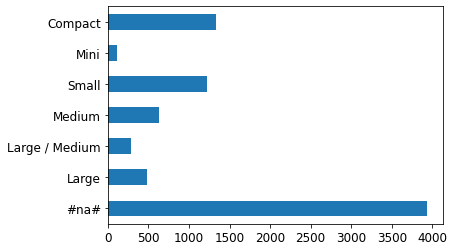

In [90]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

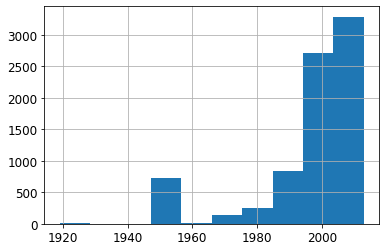

In [91]:
ax = valid_xs_final['YearMade'].hist()

The largrest group is `#na#`, which is the label fastai applies to missing values.

Let's do the same thing for `YearMade`. Since this is a numeric feature, we'll need to draw a histogram, which groups the year values into a few discrete bins

Then we do the same for 1951, 1952, and so forth until our final year of 2011. This isolates the effect of only YearMade (even if it does so by averaging over some imagined records where we assign a YearMade value that might never actually exist alongside some other values).

With these averages, we can then plot each of these years on the x-axis, and each of the predictions on the y-axis. This, finally, is a partial dependence plot. Let's take a look:

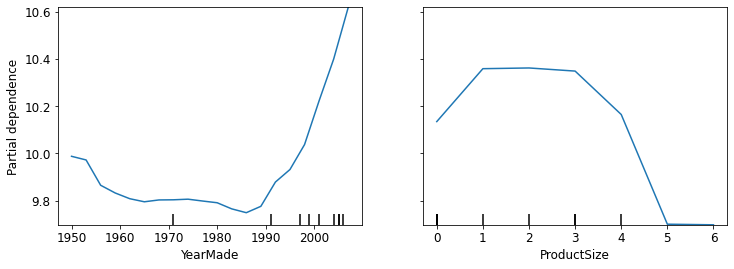

In [92]:
# need to check this cell
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

Looking first of all at the YearMade plot, and specifically at the section covering the years after 1990 (since as we noted this is where we have the most data), we can see a nearly linear relationship between year and price. Remember that our dependent variable is after taking the logarithm, so this means that in practice there is an exponential increase in price. This is what we would expect: depreciation is generally recognized as being a multiplicative factor over time, so, for a given sale date, varying year made ought to show an exponential relationship with sale price.

The ProductSize partial plot is a bit concerning. It shows that the final group, which we saw is for missing values, has the lowest price. To use this insight in practice, we would want to find out why it's missing so often, and what that means. Missing values can sometimes be useful predictors—it entirely depends on what causes them to be missing. Sometimes, however, they can indicate data leakage.

### Data Leakage

A model that thinks that it rains on rainy days, cause overrides the effect

### Tree intrepreter

In [93]:
!pip install treeinterpreter

In [94]:
!pip install waterfallcharts

  Created wheel for waterfallcharts: filename=waterfallcharts-3.8-cp36-none-any.whl size=3415 sha256=2de5009140f1303557e6d3b89a39d74b17e482723af44a4cfdf749c866ab432e
  Stored in directory: /root/.cache/pip/wheels/f9/be/d0/59ccb7fc5d874cbea7cbfcf89e42feccfe8fa18a90a1bf4370
Successfully built waterfallcharts


In [95]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [96]:
row = valid_xs_final.iloc[:5]

In [97]:
prediction, bias, contributions =  treeinterpreter.predict(m, row.values)

In [98]:
prediction[0], bias[0], contributions[0].sum()

(array([10.01216396]), 10.104746057831765, -0.0925820990266335)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

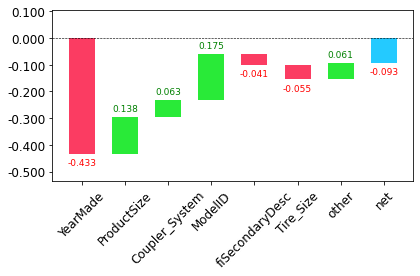

In [99]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, rotation_value=45, formatting='{:,.3f}')

### training neural networks

Extrapolation problem that is they dont work well with new data. By they I mean random forests

In [100]:
np.random.seed(42)

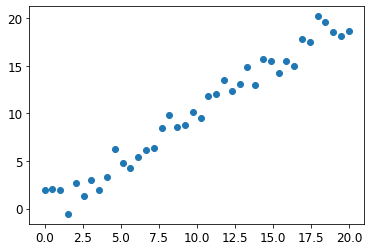

In [102]:
x_lin = torch.linspace(0,20,steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin)

In [103]:
#we only have a single independent variable, 
#sklearn expects a matrix of independent variables, 
#not a single vector. So we have to turn our vector into a matrix with one column. 
#In other words, we have to change the shape from [40] to [40,1]. One way to do that is with the unsqueeze method, 
#which adds a new unit axis to a tensor at the requested dimension:

xs_lin = x_lin.unsqueeze(1)
x_lin.shape, xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [104]:
x_lin[:,None].shape

torch.Size([40, 1])

In [105]:
m_lin = RandomForestRegressor().fit(xs_lin[:30], y_lin[:30])

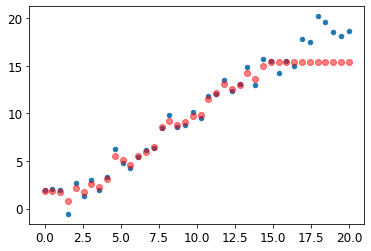

In [107]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5)

random forest cannot predcit outside the domain of training data

### finding out of domain data

But in this case we don't use the random forest to predict our actual dependent variable. Instead, we try to predict whether a row is in the validation set or the training set. To see this in action, let's combine our training and validation sets together, create a dependent variable that represents which dataset each row comes from, build a random forest using that data, and get its feature importance:

In [109]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final)+[1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
6,saleElapsed,0.870436
9,SalesID,0.097691
14,MachineID,0.024457
0,YearMade,0.001897
5,ModelID,0.001393
8,fiModelDesc,0.000781


the table shows the columns that varies significantly with the data.

we will get the baseline and then try removing each of the feature in turn

In [113]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID', 'saleElapsed', 'MachineID'):
  m = rf(xs_final.drop(c, axis=1), y)
  print(c, m_rmse(m, valid_xs_final.drop(c, axis=1), valid_y))

# its so simple to drop tables like that

orig 0.232899
SalesID 0.231035
saleElapsed 0.234619
MachineID 0.231901


In [114]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.229018

also avoid using old data. Because that doesn't help.

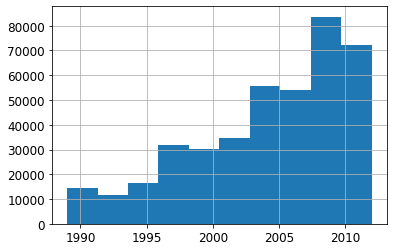

In [115]:
xs['saleYear'].hist()

In [116]:
filt = xs['saleYear'] > 2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [117]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

# somtimes a subset of data is better

(0.17747, 0.228763)

### Using a Neural Network , fr this time

In [139]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [143]:
dep_var

'SalePrice'

In [140]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [144]:
df_nn_final.head()

,YearMade,ProductSize,Coupler_System,fiProductClassDesc,...,fiModelDescriptor,Drive_System,Tire_Size,SalePrice
0,2004,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,...,NaN,NaN,None or Unspecified,11.097410
1,1996,Medium,NaN,Wheel Loader - 150.0 to 175.0 Horsepower,...,NaN,NaN,23.5,10.950807
2,2001,NaN,None or Unspecified,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,...,NaN,NaN,NaN,9.210340
3,2001,Small,NaN,"Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons",...,NaN,NaN,NaN,10.558414
4,2007,NaN,None or Unspecified,Skid Steer Loader - 1601.0 to 1751.0 Lb Operating Capacity,...,NaN,NaN,NaN,9.305651


Categorical columns are handled very differently in neural networks, compared to decision tree approaches. As we saw in chapter_collab, in a neural net a great way to handle categorical variables is by using embeddings. To create embeddings, fastai needs to determine which columns should be treated as categorical variables. It does this by comparing the number of distinct levels in the variable to the value of the `max_card` parameter. If it's lower, fastai will treat the variable as categorical. Embedding sizes larger than 10,000 should generally only be used after you've tested whether there are better ways to group the variable, so we'll use 9,000 as our `max_card`:


In [145]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [146]:
# we want the saleElapsed to be treated as a continous

cont_nn.append('saleElapsed')
cat_nn.remove('saleElapsed')

In [147]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
Hydraulics_Flow          3
ModelID               5281
fiSecondaryDesc        177
fiModelDesc           5059
Enclosure                6
Hydraulics              12
ProductGroup             6
fiModelDescriptor      140
Drive_System             4
Tire_Size               17
dtype: int64

In [148]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.176612, 0.229261)

In [149]:
cat_nn.remove('fiModelDescriptor')

In [160]:
# https://forums.fast.ai/t/09-tabular-value-error-unable-to-coerce-to-series-length-must-be-1-given-0/80580

procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, 
                      splits=splits,
                      y_names=dep_var)

In [161]:
dls = to_nn.dataloaders(1024)

In [162]:
y = to_nn.train.y
y.min(), y.max()

(8.465899467468262, 11.863582611083984)

### Using learner

In [165]:
from fastai.tabular.all import *
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)


SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.00019054606673307717)

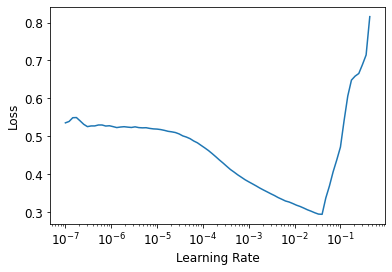

In [166]:
learn.lr_find()

In [167]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.103697,0.093719,00:56
1,0.095035,0.074761,00:55
2,0.090092,0.073094,00:55
3,0.086692,0.070409,00:55
4,0.084135,0.073196,00:55


In [168]:
preds, targs = learn.get_preds()
r_mse(preds, targs)

0.270547

In [169]:
learn.save('nn')

Path('models/nn.pth')

### Ensembling, et too
As we saw earlier, a random forest is itself an ensemble. But we can then include a random forest in another ensemble—an ensemble of the random forest and the neural network! 

In [170]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [171]:
r_mse(ens_preds, valid_y)

0.232907

### Boosting

We are not going to go into detail on how to train a gradient boosted tree ensemble here, because the field is moving rapidly, and any guidance we give will almost certainly be outdated by the time you read this. As we write this, sklearn has just added a `HistGradientBoostingRegressor` class that provides excellent performance. There are many hyperparameters to tweak for this class, and for all gradient boosted tree methods we have seen. Unlike random forests, gradient boosted trees are extremely sensitive to the choices of these hyperparameters; in practice, most people use a loop that tries a range of different hyperparameters to find the ones that work best.
